# Data Analysis
## DuckDB Python Client Basics
Author: Mark Bauer

In [1]:
import duckdb
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import requests

In [2]:
# reproducibility
%reload_ext watermark
%watermark -v -p duckdb,pandas

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb: 1.0.0
pandas: 1.5.1



This notebook demonstrates a sample analysis examining green infrastructure projects in New York City.

Dataset on NYC Open Data: https://data.cityofnewyork.us/Environment/DEP-Green-Infrastructure/spjh-pz7h

In [3]:
# reading in a CSV by opening a connection and copying data to a table
con = duckdb.connect()

# create table green_infrastructure
con.sql(
    """
    CREATE TABLE green_infrastructure
    AS FROM read_csv('data/green_infrastructure.csv')
    """
)

# sanity check against new table
con.sql(
    """
    SELECT *
    FROM green_infrastructure
    LIMIT 10
    """
)

┌──────────────────────┬──────────┬─────────┬────────────┬───┬────────────┬────────────────────┬─────────────┐
│       the_geom       │ Asset_ID │  GI_ID  │ DEP_Contra │ … │ Construc_1 │     Program_Ar     │ Status_Gro  │
│       varchar        │  int64   │ varchar │  varchar   │   │  varchar   │      varchar       │   varchar   │
├──────────────────────┼──────────┼─────────┼────────────┼───┼────────────┼────────────────────┼─────────────┤
│ POINT (-73.8116762…  │    94002 │ 1A      │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8122857…  │    94012 │ GS6A    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8122344…  │    94017 │ GS8C    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8120597…  │    94019 │ GS8E    │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│ POINT (-73.8131019…  │    94021 │ 10A     │ GQJA03-02  │ … │ Package-1  │ Right of Way (ROW) │ Constructed │
│

In [4]:
# list tables
con.sql("SHOW TABLES").df()

,name
0,green_infrastructure


In [5]:
# list tables and schemas
con.sql("SHOW ALL TABLES").df()

,database,schema,name,column_names,column_types,temporary
0,memory,main,green_infrastructure,"[the_geom, Asset_ID, GI_ID, DEP_Contra, DEP_Co...","[VARCHAR, BIGINT, VARCHAR, VARCHAR, VARCHAR, V...",False


In [6]:
# count rows
con.sql(
    """
    SELECT COUNT(Asset_ID) AS count_rows
    FROM green_infrastructure
    """
)

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│      14346 │
└────────────┘

In [7]:
# inspect column information
sql = """
    DESCRIBE SELECT *
    FROM green_infrastructure
"""

con.sql(sql).show(max_rows=30)

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ the_geom    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Asset_ID    │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ GI_ID       │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ DEP_Contra  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ DEP_Cont_1  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Row_Onsite  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Project_Na  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Asset_Type  │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Status      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ Asset_X_Co  │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ Asset_Y_Co  │ DOUB

In [8]:
# descriptive statistics of columns
sql = """
    SUMMARIZE SELECT *
    FROM green_infrastructure
"""

con.sql(sql).show(max_rows=30)

┌─────────────┬─────────────┬──────────────────────┬───┬────────────────────┬───────┬─────────────────┐
│ column_name │ column_type │         min          │ … │        q75         │ count │ null_percentage │
│   varchar   │   varchar   │       varchar        │   │      varchar       │ int64 │  decimal(9,2)   │
├─────────────┼─────────────┼──────────────────────┼───┼────────────────────┼───────┼─────────────────┤
│ the_geom    │ VARCHAR     │ POINT (-73.7267005…  │ … │ NULL               │ 14346 │            0.00 │
│ Asset_ID    │ BIGINT      │ 94002                │ … │ 182607             │ 14346 │            0.00 │
│ GI_ID       │ VARCHAR     │ 0005A                │ … │ NULL               │ 14346 │            0.00 │
│ DEP_Contra  │ VARCHAR     │ B008-111M            │ … │ NULL               │ 14346 │            0.00 │
│ DEP_Cont_1  │ VARCHAR     │ 1                    │ … │ NULL               │ 14346 │            0.00 │
│ Row_Onsite  │ VARCHAR     │ Onsite               │ … │ NULL   

In [9]:
# push to dataframe for readability
con.sql(sql).df()

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,the_geom,VARCHAR,POINT (-73.72670059525332 40.68553896404729),POINT (-74.25397969155536 40.50233194249483),14362,None,None,None,None,None,14346,0.00
1,Asset_ID,BIGINT,94002,190896,14202,152289.4963055904,30476.34806145504,123874,157262,182607,14346,0.00
2,GI_ID,VARCHAR,0005A,sgs594,13346,None,None,None,None,None,14346,0.00
3,DEP_Contra,VARCHAR,B008-111M,ZTESTZ,542,None,None,None,None,None,14346,0.00
4,DEP_Cont_1,VARCHAR,1,PI,10,None,None,None,None,None,14346,0.00
5,Row_Onsite,VARCHAR,Onsite,ROW,2,None,None,None,None,None,14346,0.00
6,Project_Na,VARCHAR,1 Dekalb Avenue,test,575,None,None,None,None,None,14346,0.00
7,Asset_Type,VARCHAR,Blue Roof,Synthetic Turf Field Storage Layer,30,None,None,None,None,None,14346,0.00
8,Status,VARCHAR,100% Design Accepted,In Construction,8,None,None,None,None,None,14346,0.00
9,Asset_X_Co,DOUBLE,913617.59773,1060047.0,14383,1018561.2245338603,15748.986955729739,1007143.6092308176,1017926.0456971781,1031686.6875302786,14346,0.00


In [10]:
# inspect count NULL
summarize = """
    SUMMARIZE SELECT *
    FROM green_infrastructure
"""

summarize_relation = con.sql(summarize)

sql = """
    SELECT column_name, column_type, null_percentage
    FROM summarize_relation
    ORDER BY null_percentage DESC
"""

con.sql(sql).show(max_rows=30)

┌─────────────┬─────────────┬─────────────────┐
│ column_name │ column_type │ null_percentage │
│   varchar   │   varchar   │  decimal(9,2)   │
├─────────────┼─────────────┼─────────────────┤
│ GI_Feature  │ VARCHAR     │           15.70 │
│ Tree_Latin  │ VARCHAR     │           13.11 │
│ Tree_Commo  │ VARCHAR     │           13.11 │
│ Constructi  │ VARCHAR     │            9.70 │
│ Construc_1  │ VARCHAR     │            9.70 │
│ the_geom    │ VARCHAR     │            0.00 │
│ Asset_ID    │ BIGINT      │            0.00 │
│ GI_ID       │ VARCHAR     │            0.00 │
│ DEP_Contra  │ VARCHAR     │            0.00 │
│ DEP_Cont_1  │ VARCHAR     │            0.00 │
│ Row_Onsite  │ VARCHAR     │            0.00 │
│ Project_Na  │ VARCHAR     │            0.00 │
│ Asset_Type  │ VARCHAR     │            0.00 │
│ Status      │ VARCHAR     │            0.00 │
│ Asset_X_Co  │ DOUBLE      │            0.00 │
│ Asset_Y_Co  │ DOUBLE      │            0.00 │
│ Borough     │ VARCHAR     │           

In [11]:
# inspect data
sql = """
    SELECT *
    FROM green_infrastructure
    LIMIT 5   
"""

# examine first 15 columns
con.sql(sql).df().iloc[:, :15]

,the_geom,Asset_ID,GI_ID,DEP_Contra,DEP_Cont_1,Row_Onsite,Project_Na,Asset_Type,Status,Asset_X_Co,Asset_Y_Co,Borough,Sewer_Type,Outfall,NYC_Waters
0,POINT (-73.81167623024226 40.69138622900597),94002,1A,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWB,Constructed (Full Maintenance),1.036475e+06,191223.22700,Queens,Combined,JAM-003,Jamaica Bay and Tributaries
1,POINT (-73.81228577606385 40.69238458134393),94012,GS6A,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWGS,Constructed (Full Maintenance),1.036305e+06,191586.59230,Queens,Combined,JAM-003,Jamaica Bay and Tributaries
2,POINT (-73.8122344420821 40.69312522070409),94017,GS8C,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWGS,Constructed (Full Maintenance),1.036319e+06,191856.45894,Queens,Combined,JAM-003,Jamaica Bay and Tributaries
3,POINT (-73.8120597400255 40.6931738947353),94019,GS8E,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWGS,Constructed (Full Maintenance),1.036368e+06,191874.29620,Queens,Combined,JAM-003,Jamaica Bay and Tributaries
4,POINT (-73.81310191327061 40.69279332424906),94021,10A,GQJA03-02,2,ROW,DDC JAM-003 Phase 2,ROWB,Constructed (Full Maintenance),1.036079e+06,191735.02499,Queens,Combined,JAM-003,Jamaica Bay and Tributaries


In [12]:
# examine last 15 columns
con.sql(sql).df().iloc[:, 15:]

,BBL,Secondary_,Community_,City_Counc,Assembly_D,Asset_Leng,Asset_Widt,Asset_Area,GI_Feature,Tree_Latin,Tree_Commo,Constructi,Construc_1,Program_Ar,Status_Gro
0,4095890001,0,410,28,32,17.0,5.0,85.0,Standard,Chionanthus retusus,Chinese Fringetree,GCJA03-2A,Package-1,Right of Way (ROW),Constructed
1,4095020030,4095020028,409,28,32,13.0,3.5,45.5,None,No Tree,N/A,GCJA03-2A,Package-1,Right of Way (ROW),Constructed
2,4095030001,0,409,28,32,20.0,3.5,70.0,None,No Tree,N/A,GCJA03-2A,Package-1,Right of Way (ROW),Constructed
3,4095030001,0,409,28,32,20.0,3.5,70.0,None,No Tree,N/A,GCJA03-2A,Package-1,Right of Way (ROW),Constructed
4,4095020063,0,409,28,32,13.0,4.0,52.0,Standard,Quercus palustris,Pin Oak,GCJA03-2A,Package-1,Right of Way (ROW),Constructed


In [13]:
# inspect duplicate asset ids
con.sql("""
    SELECT
        Asset_ID,
        count(Asset_ID) AS count
    FROM green_infrastructure
    GROUP BY Asset_ID
    HAVING count > 1
    ORDER BY count DESC  
""")

┌──────────┬───────┐
│ Asset_ID │ count │
│  int64   │ int64 │
├──────────┴───────┤
│      0 rows      │
└──────────────────┘

Descriptions:  
ROWB: Right of Way Bioswale, ROWEB: Right of Way Enhanced Bioretention, ROWGS: Right of Way Greenstrip, ROWRG: Right of Way Rain Garden, ROWSGS: Right of Way Stormwater Greenstreet

In [14]:
# examine Asset_Type distribution
con.sql("""
    SELECT
        Asset_Type,
        count(Asset_ID) AS count
    FROM green_infrastructure
    GROUP BY Asset_Type
    ORDER BY count DESC 
    LIMIT 20
""")

┌───────────────────────────────────────────────────────────────────┬───────┐
│                            Asset_Type                             │ count │
│                              varchar                              │ int64 │
├───────────────────────────────────────────────────────────────────┼───────┤
│ ROWB                                                              │  7212 │
│ ROW Infiltration Basin with Concrete Top                          │  3776 │
│ ROW Infiltration Basin with Grass Top                             │   952 │
│ ROWGS                                                             │   387 │
│ Rain Garden                                                       │   299 │
│ ROWRG                                                             │   250 │
│ Permeable Pavers                                                  │   207 │
│ ROW Porous Concrete                                               │   199 │
│ Subsurface Storage                                            

In [15]:
# examine Asset_Type distinct counts
con.sql("""
    SELECT
        COUNT(DISTINCT Asset_Type) AS asset_type_unique
    FROM green_infrastructure
""")

┌───────────────────┐
│ asset_type_unique │
│       int64       │
├───────────────────┤
│                30 │
└───────────────────┘

In [16]:
# Borough
con.sql("""
    SELECT
        Borough,
        count(Asset_ID) AS count
    FROM green_infrastructure
    GROUP BY Borough
    ORDER BY count DESC  
""")

┌───────────────┬───────┐
│    Borough    │ count │
│    varchar    │ int64 │
├───────────────┼───────┤
│ Queens        │  7077 │
│ Brooklyn      │  5997 │
│ Bronx         │  1015 │
│ Manhattan     │   192 │
│ Staten Island │    65 │
└───────────────┴───────┘

In [17]:
# Sewer_Type
con.sql("""
    SELECT
        Sewer_Type,
        count(Asset_ID) AS count
    FROM green_infrastructure
    GROUP BY Sewer_Type
    ORDER BY count DESC  
""")

┌────────────────────┬───────┐
│     Sewer_Type     │ count │
│      varchar       │ int64 │
├────────────────────┼───────┤
│ Combined           │ 14002 │
│ MS4                │   250 │
│ Non-combined       │    89 │
│ On-site management │     3 │
│ Separate           │     2 │
└────────────────────┴───────┘

In [18]:
# NYC_Waters - The name of the body of water whose watershed contains the asset
con.sql("""
    SELECT
        NYC_Waters,
        count(Asset_ID) AS count
    FROM green_infrastructure
    GROUP BY NYC_Waters
    ORDER BY count DESC  
""")

┌─────────────────────────────┬───────┐
│         NYC_Waters          │ count │
│           varchar           │ int64 │
├─────────────────────────────┼───────┤
│ Jamaica Bay and Tributaries │  6556 │
│ East River / Open Waters    │  2197 │
│ Flushing Creek              │  2179 │
│ Newtown Creek               │  1580 │
│ Flushing Bay                │   791 │
│ Bronx River                 │   442 │
│ Westchester Creek           │   224 │
│ Hutchinson River            │   194 │
│ Gowanus Canal               │   124 │
│ Coney Island Creek          │    49 │
│ Alley Creek                 │    10 │
├─────────────────────────────┴───────┤
│ 11 rows                   2 columns │
└─────────────────────────────────────┘

In [19]:
# Tree_Common_Name - Species of tree included in the asset, common name
con.sql("""
    SELECT
        Tree_Commo,
        count(Asset_ID) AS count
    FROM green_infrastructure
    GROUP BY Tree_Commo
    ORDER BY count DESC  
    LIMIT 10
""")

┌──────────────────────────────┬───────┐
│          Tree_Commo          │ count │
│           varchar            │ int64 │
├──────────────────────────────┼───────┤
│ N/A                          │  9098 │
│ NULL                         │  1881 │
│ Swamp White Oak              │   316 │
│ Pin Oak                      │   195 │
│ Sweetgum                     │   157 │
│ Japanese Zelkova             │   154 │
│ Thornless Common Honeylocust │   147 │
│ Shadblow Serviceberry        │   108 │
│ Sawtooth Oak                 │   102 │
│ Ginkgo Tree                  │   100 │
├──────────────────────────────┴───────┤
│ 10 rows                    2 columns │
└──────────────────────────────────────┘

In [20]:
# GI_Feature - The category of green infrastructure that the asset belongs to
con.sql("""
    SELECT
        GI_Feature,
        count(Asset_ID) AS count
    FROM green_infrastructure
    GROUP BY GI_Feature
    ORDER BY count DESC  
""")

┌───────────────────────────────────────────┬───────┐
│                GI_Feature                 │ count │
│                  varchar                  │ int64 │
├───────────────────────────────────────────┼───────┤
│ Standard                                  │  7325 │
│ Type C - SW Chamber                       │  2566 │
│ NULL                                      │  2253 │
│ Type A - Stone Columns                    │  1944 │
│ Type D                                    │   218 │
│ Type DA                                   │    19 │
│ Type B/C - Stormwater Inlet/SW Chamber    │    12 │
│ Type B - Stormwater Inlet                 │     7 │
│ Type A/B - Stone Columns/Stormwater Inlet │     2 │
└───────────────────────────────────────────┴───────┘

In [21]:
# descriptive statistics of project size
summarize_relation = con.sql("SUMMARIZE SELECT * FROM green_infrastructure")

summarize_df = con.sql(
    """
    SELECT *
    FROM summarize_relation
    WHERE column_name in ('Asset_Leng', 'Asset_Widt', 'Asset_Area')
    """
).df()

summarize_df

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,Asset_Leng,DOUBLE,0.0,2110.0,354,19.904144012268233,55.02109722417139,10.0,13.0,18.737664707977203,14346,0.0
1,Asset_Widt,DOUBLE,0.0,296.0,180,4.888799665411963,5.588872247882706,4.0,4.500818181818182,5.0,14346,0.0
2,Asset_Area,DOUBLE,1.0,435000.0,1257,471.68455039732345,5839.1771255425065,51.25460482081967,65.1293739360696,97.57023525246994,14346,0.0


In [22]:
# largest five projects - The footprint area of the asset in square feet
sql = """
    SELECT *
    FROM green_infrastructure
    ORDER BY Asset_Area DESC
    LIMIT 5
    """

con.sql(sql).df().iloc[:, :15]

,the_geom,Asset_ID,GI_ID,DEP_Contra,DEP_Cont_1,Row_Onsite,Project_Na,Asset_Type,Status,Asset_X_Co,Asset_Y_Co,Borough,Sewer_Type,Outfall,NYC_Waters
0,POINT (-74.00229569924448 40.757951817712886),138087,JCGR-1,PRIVATE_GR,OA,Onsite,Javits Center Green Roof,Green Roof,Constructed,9.836140e+05,215419.00000,Manhattan,Combined,NR-028,East River / Open Waters
1,POINT (-74.19545588457119 40.561950486557514),187241,Freshkills1,RG-12450-506M,1,Onsite,Freshkills Park Owl Hollow Fields Construction,Synthetic Turf Field Storage Layer,Constructed,9.299417e+05,144070.78177,Staten Island,MS4,OVERLAND FLOW ER,East River / Open Waters
2,POINT (-73.90532182350593 40.72771532765737),187205,FrankP1,Q131-115M,1,Onsite,Frank Principe Park Ballfields Reconstruction,Synthetic Turf Field Storage Layer,Constructed,1.010492e+06,204417.05689,Queens,Combined,NCQ-077,Newtown Creek
3,POINT (-74.00553985329056 40.67329044837725),187266,SWPS21-113-D01,B126-116M,1,Onsite,Red Hook Recreation Area Remediation and Recon...,Synthetic Turf Field Storage Layer,Constructed,9.827133e+05,184574.31997,Brooklyn,Non-combined,RH-503,Gowanus Canal
4,POINT (-73.87308060078496 40.67026320022855),187191,B103-01STa,B103-116M,1,Onsite,Cypress Hills PG - Synthetic Turf Field Constr...,Synthetic Turf Field Storage Layer,Constructed,1.019458e+06,183496.86500,Brooklyn,Combined,26W-005,Jamaica Bay and Tributaries


In [23]:
con.sql(sql).df().iloc[:, 15:]

,BBL,Secondary_,Community_,City_Counc,Assembly_D,Asset_Leng,Asset_Widt,Asset_Area,GI_Feature,Tree_Latin,Tree_Commo,Constructi,Construc_1,Program_Ar,Status_Gro
0,1006800001,0,0,0,0,0.0,0.0,435000.0,None,None,None,None,None,External,Constructed
1,5059650084,0,503,51,62,0.0,0.0,303481.0,None,None,None,None,None,External,Constructed
2,4026560086,0,405,30,37,0.0,0.0,156052.0,None,None,None,None,None,External,Constructed
3,3005820001,0,306,38,51,0.0,0.0,145471.0,None,None,None,None,None,External,Constructed
4,3042920161,0,305,42,60,439.0,296.0,130383.0,None,None,None,None,None,External,Constructed


NYC Neighborhood Boundaries: https://www.nyc.gov/site/planning/data-maps/open-data/census-download-metadata.page

In [24]:
# install DuckDB spatial extension
con.install_extension("spatial")
con.load_extension("spatial")

In [25]:
# create table neighborhoods
con.sql(
    """
    CREATE TABLE neighborhoods AS
        SELECT *
        FROM ST_Read('/vsizip/data/nynta2020_24c.zip/nynta2020_24c')
    """
)

# sanity check new table
con.sql(
    """
    SELECT *
    FROM neighborhoods
    LIMIT 5
    """
)

┌──────────┬──────────┬────────────┬─────────┬───┬───────────────┬───────────────┬──────────────────────┐
│ BoroCode │ BoroName │ CountyFIPS │ NTA2020 │ … │  Shape_Leng   │  Shape_Area   │         geom         │
│  int32   │ varchar  │  varchar   │ varchar │   │    double     │    double     │       geometry       │
├──────────┼──────────┼────────────┼─────────┼───┼───────────────┼───────────────┼──────────────────────┤
│        3 │ Brooklyn │ 047        │ BK0101  │ … │ 28912.5663222 │ 35321206.6726 │ POLYGON ((1003059.…  │
│        3 │ Brooklyn │ 047        │ BK0102  │ … │ 28098.0270184 │ 28854314.2319 │ POLYGON ((994849.0…  │
│        3 │ Brooklyn │ 047        │ BK0103  │ … │ 18250.2802623 │ 15208960.6551 │ POLYGON ((998047.2…  │
│        3 │ Brooklyn │ 047        │ BK0104  │ … │ 43184.7730868 │  52266211.208 │ POLYGON ((1005302.…  │
│        3 │ Brooklyn │ 047        │ BK0201  │ … │ 14312.5048671 │ 9982321.60824 │ POLYGON ((986367.7…  │
├──────────┴──────────┴────────────┴─────────┴

In [26]:
# view as dataframe
con.sql(
    """
    SELECT *
    FROM neighborhoods
    LIMIT 2
    """
).df()

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geom
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566322,3.532121e+07,"[2, 4, 0, 0, 0, 0, 0, 0, 239, 215, 114, 73, 93..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.027018,2.885431e+07,"[2, 4, 0, 0, 0, 0, 0, 0, 186, 81, 114, 73, 212..."


In [27]:
# sanity check against green_infrastructure table, coords need to flip to join on Neighborhood CRS
con.sql(
    """
    SELECT ST_FlipCoordinates(ST_GeomFromText(green_infrastructure.the_geom))
    FROM green_infrastructure
    LIMIT 2
    """
).show()

┌────────────────────────────────────────────────────────────────────┐
│ st_flipcoordinates(st_geomfromtext(green_infrastructure.the_geom)) │
│                              geometry                              │
├────────────────────────────────────────────────────────────────────┤
│ POINT (40.69138622900597 -73.81167623024226)                       │
│ POINT (40.69238458134393 -73.81228577606385)                       │
└────────────────────────────────────────────────────────────────────┘



In [28]:
# spatial join projects on boroughs
spatial_join = con.sql(
    """
    SELECT
        *,
        NTAName || ', ' || BoroName AS nta_name_full
    FROM green_infrastructure
    JOIN neighborhoods ON ST_Within(
        ST_Transform(ST_FlipCoordinates(ST_GeomFromText(green_infrastructure.the_geom)), 'EPSG:4326', 'EPSG:2263'),
        neighborhoods.geom
    )
    """
)

# group by Neighborhood
merged_nta = con.sql(
    """
    SELECT
        NTA2020,
        nta_name_full,
        COUNT(*) AS count,
        ROUND(SUM(Asset_Area), 2) AS total_asset_area
    FROM spatial_join
    GROUP BY NTA2020, nta_name_full
    """
)
    
# normalize values by neighborhood area
df = con.sql(
    """
    SELECT
        nta_name_full,
        count,
        count / Shape_Area::BIGINT AS count_norm,
        total_asset_area,
        total_asset_area / Shape_Area::BIGINT AS total_asset_area_norm,
    FROM merged_nta
    LEFT JOIN neighborhoods USING (NTA2020)
    ORDER BY total_asset_area DESC
    """
).df()

# sanity check
df.head()

,nta_name_full,count,count_norm,total_asset_area,total_asset_area_norm
0,"Chelsea-Hudson Yards, Manhattan",10,3.370209e-07,442415.38,0.014910
1,"Freshkills Park (South), Staten Island",3,6.281569e-08,309156.00,0.006473
2,"Brownsville, Brooklyn",484,1.572167e-05,234344.96,0.007612
3,"Bensonhurst, Brooklyn",168,3.454307e-06,229623.00,0.004721
4,"East New York-City Line, Brooklyn",260,8.246332e-06,203111.38,0.006442


In [29]:
# top five projects by neighborhood
df.sort_values(by='count', ascending=False).head(5)

,nta_name_full,count,count_norm,total_asset_area,total_asset_area_norm
31,"South Ozone Park, Queens",834,0.000010,51964.50,0.000635
23,"East Flatbush-Rugby, Brooklyn",681,0.000025,62157.50,0.002285
19,"Canarsie, Brooklyn",661,0.000009,80566.55,0.001142
47,"East New York (North), Brooklyn",548,0.000020,39965.80,0.001432
2,"Brownsville, Brooklyn",484,0.000016,234344.96,0.007612


In [30]:
# top five projects by total area
df.sort_values(by='total_asset_area', ascending=False).head(5)

,nta_name_full,count,count_norm,total_asset_area,total_asset_area_norm
0,"Chelsea-Hudson Yards, Manhattan",10,3.370209e-07,442415.38,0.014910
1,"Freshkills Park (South), Staten Island",3,6.281569e-08,309156.00,0.006473
2,"Brownsville, Brooklyn",484,1.572167e-05,234344.96,0.007612
3,"Bensonhurst, Brooklyn",168,3.454307e-06,229623.00,0.004721
4,"East New York-City Line, Brooklyn",260,8.246332e-06,203111.38,0.006442


In [31]:
# retrieve neighborhood boundaries used for plotting
path = "data/nynta2020_24c.zip!nynta2020_24c"

nta_gdf = gpd.read_file(path)
nta_gdf['nta_name_full'] = nta_gdf['NTAName'] + ', ' + nta_gdf['BoroName']

nta_gdf.head()

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry,nta_name_full
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566322,3.532121e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...","Greenpoint, Brooklyn"
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.027018,2.885431e+07,"POLYGON ((994849.011 203499.267, 994911.093 20...","Williamsburg, Brooklyn"
2,3,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280262,1.520896e+07,"POLYGON ((998047.210 196303.325, 998157.901 19...","South Williamsburg, Brooklyn"
3,3,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773087,5.226621e+07,"POLYGON ((1005302.497 199455.730, 1005307.792 ...","East Williamsburg, Brooklyn"
4,3,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504867,9.982322e+06,"POLYGON ((986367.735 190549.239, 985813.835 19...","Brooklyn Heights, Brooklyn"


In [32]:
# merge data on GeoDataFrame
nta_merged = nta_gdf.merge(
    df,
    on='nta_name_full',
    how='left'
)

print(nta_merged.shape)
nta_merged.head()

(262, 17)


,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry,nta_name_full,count,count_norm,total_asset_area,total_asset_area_norm
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566322,3.532121e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...","Greenpoint, Brooklyn",11.0,3.114276e-07,33840.00,0.000958
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.027018,2.885431e+07,"POLYGON ((994849.011 203499.267, 994911.093 20...","Williamsburg, Brooklyn",2.0,6.931373e-08,40300.00,0.001397
2,3,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280262,1.520896e+07,"POLYGON ((998047.210 196303.325, 998157.901 19...","South Williamsburg, Brooklyn",36.0,2.367026e-06,12137.50,0.000798
3,3,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.773087,5.226621e+07,"POLYGON ((1005302.497 199455.730, 1005307.792 ...","East Williamsburg, Brooklyn",85.0,1.626290e-06,53806.36,0.001029
4,3,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504867,9.982322e+06,"POLYGON ((986367.735 190549.239, 985813.835 19...","Brooklyn Heights, Brooklyn",NaN,NaN,NaN,NaN


In [33]:
# examine summary statistics
nta_merged[['count', 'total_asset_area']].describe()

,count,total_asset_area
count,208.000000,208.000000
mean,68.971154,32532.627692
std,129.211279,53904.446550
min,1.000000,132.000000
25%,3.000000,5843.850000
50%,10.000000,12823.250000
75%,60.750000,38164.550000
max,834.000000,442415.380000


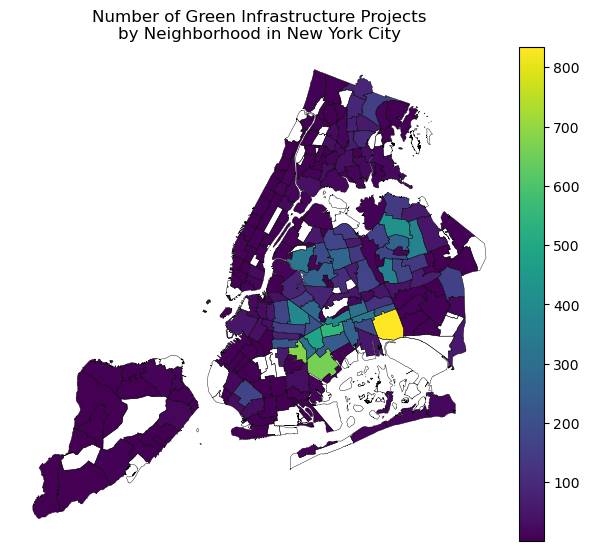

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.viridis

nta_merged.plot(
    column='count',
    legend=True,
    cmap=cmap,
    cax=cax,
    ax=ax,
)

nta_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.3
)

ax.set_title('Number of Green Infrastructure Projects\n\
by Neighborhood in New York City')
ax.axis('off')
plt.tight_layout()

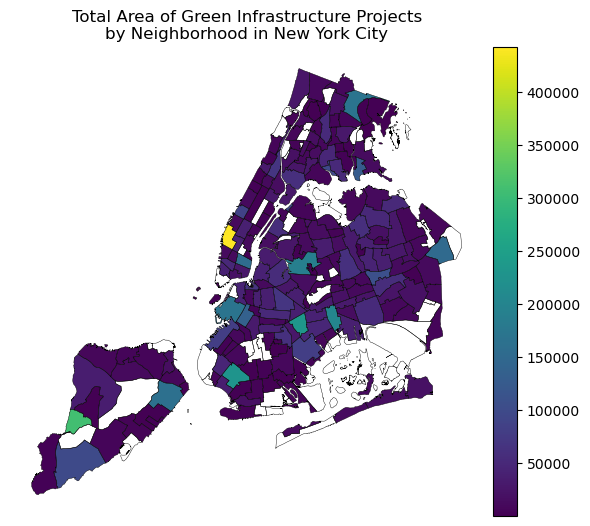

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.viridis

nta_merged.plot(
    column='total_asset_area',
    legend=True,
    cmap=cmap,
    cax=cax,
    ax=ax,
)

nta_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.3
)

ax.set_title('Total Area of Green Infrastructure Projects\n\
by Neighborhood in New York City')
ax.axis('off')
plt.tight_layout()

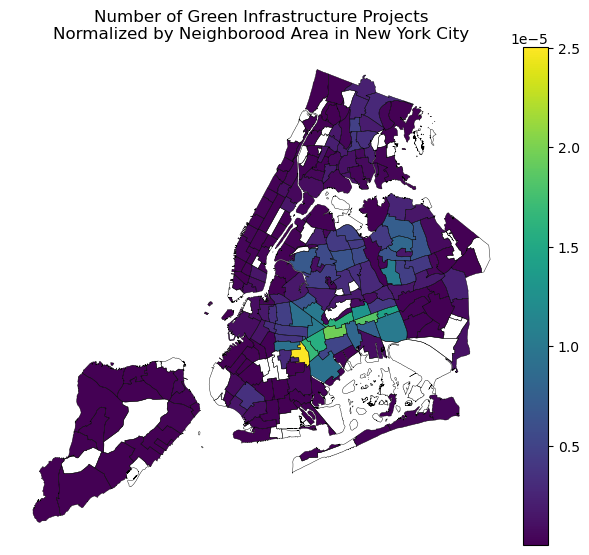

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.viridis

nta_merged.plot(
    column='count_norm',
    legend=True,
    cmap=cmap,
    cax=cax,
    ax=ax,
)

nta_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.3
)

ax.set_title('Number of Green Infrastructure Projects\n\
Normalized by Neighborood Area in New York City')
ax.axis('off')
plt.tight_layout()

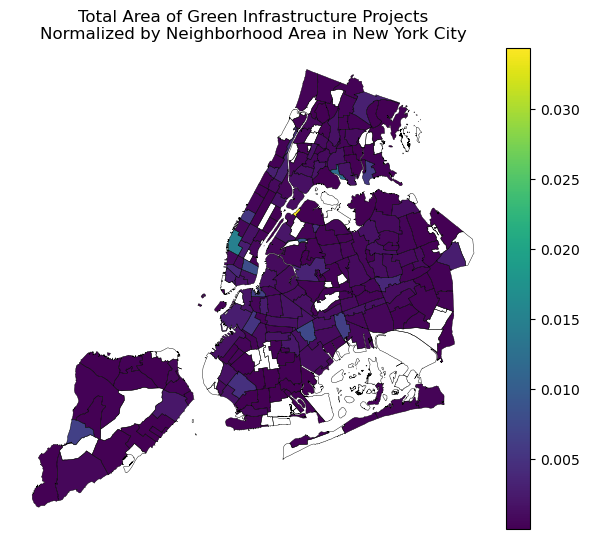

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.viridis

nta_merged.plot(
    column='total_asset_area_norm',
    legend=True,
    cmap=cmap,
    cax=cax,
    ax=ax,
)

nta_gdf.plot(
    ax=ax,
    zorder=1,
    facecolor='None',
    linewidth=.3
)

ax.set_title('Total Area of Green Infrastructure Projects\n\
Normalized by Neighborhood Area in New York City')
ax.axis('off')
plt.tight_layout()